In [8]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from numpy.testing import assert_equal
from PIL import Image
%matplotlib inline

In [9]:
#load data
path = '/Users/oziomek/licencjat/kostki/zdjecia/'
listing = os.listdir(path)
print(listing)
num_samples = 0
for folder in os.listdir(path):
    for i in range(1, 7):
        num_samples += len(os.listdir(path + folder + '/' + str(i)))
assert_equal(100800, num_samples)
print(num_samples)

data = np.array(
    [np.array(Image.open(path + folder + '/' + str(i) + '/' + file)).flatten() 
         for folder in os.listdir(path)
             for i in range(1, 7) 
                 for file in os.listdir(path + folder + '/' + str(i))], 'f')
print(data.shape)

['navyOnWhite', 'greenOnGreen', 'navyOnBlue', 'blackOnBlack', 'whiteOnBlue', 'blackOnRed', 'redOnRed', 'stainOnWhite', 'redOnRed_white', 'whiteOnBlack', 'hardLight', 'whiteOnRed', 'greenOnWhite', 'woodOnRed', 'whiteOnRed_distance']
100800
(100800, 4096)


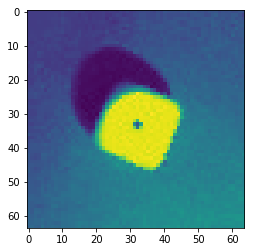

There are 1 dots, number is 63723


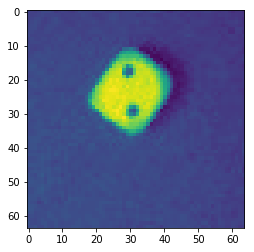

There are 2 dots, number is 29081


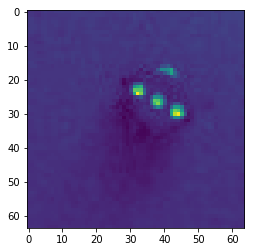

There are 3 dots, number is 21763


In [10]:
labels = np.ones((num_samples, ), dtype=int)
counter = 0
for folder in os.listdir(path):
    for i in range(1, 7):
        samples = len(os.listdir(path + folder + '/' + str(i)))
        labels[counter:counter+samples] = i-1
        counter += samples
            
rows, cols = 64, 64
labels_values = 6
train_data = [data, labels]
import random
for i in range(3):
    random_image = random.randint(0, 100800)
    img=data[random_image].reshape(rows, cols)
    plt.imshow(img)
    plt.show()
    print("There are {} dots, number is {}".format(labels[random_image] + 1, random_image))

In [45]:
(X, y) = (train_data[0], train_data[1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

print('Images:\n', X_train.shape, '\n', X_test.shape)
print('Labels:\n', y_train.shape, '\n', y_test.shape)

# X_train = X_train.reshape(X_train.shape[0], rows, cols, 1).astype('float32')
# X_test = X_test.reshape(X_test.shape[0], rows, cols, 1).astype('float32')

# normalize to 0-1
X_train /= 255
X_test /= 255

print('Images:\n', X_train.shape, '\n', X_test.shape)

y_train = tf.one_hot(y_train, 6)
y_test = tf.one_hot(y_test, 6)
print('Labels:\n', y_train.shape, '\n', y_test.shape)


Images:
 (80640, 4096) 
 (20160, 4096)
Labels:
 (80640,) 
 (20160,)
Images:
 (80640, 4096) 
 (20160, 4096)
Labels:
 (80640, 6) 
 (20160, 6)


In [16]:
def weight_variable(shape):
    init = tf.random_normal(shape, stddev=0.2)
    return tf.Variable(init)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pooling(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [17]:
x = tf.placeholder(tf.float32, [None, 4096])
y = tf.placeholder(tf.float32, [None, 6])

x_image = tf.reshape(x, [-1, 64, 64, 1])

In [18]:
W_conv1 = weight_variable([5, 5, 1, 32])

b_conv1 = weight_variable([32])

In [19]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1) # [batch_size, 64, 64, 32]

h_pool1 = max_pooling(h_conv1) # [batch_size, 32, 32, 32]

In [20]:
W_conv2 = weight_variable([5, 5, 32, 64])

b_conv2 = weight_variable([64])

In [21]:
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2) # [batch_size, 32, 32, 64]

h_pool2 = max_pooling(h_conv2) #[batch_size, 16, 16, 64]

In [22]:
keep_prob = tf.placeholder(tf.float32)

h_drop1 = tf.nn.dropout(h_pool2, keep_prob)

In [23]:
W_fconn1 = weight_variable([16*16*64, 1024])

b_fconn1 = weight_variable([1024])

h_flat = tf.reshape(h_drop1, [-1, 16*16*64])

In [24]:
h_fconn1 = tf.nn.relu(tf.matmul(h_flat, W_fconn1) + b_fconn1)

In [25]:
h_drop_2 = tf.nn.dropout(h_fconn1, keep_prob)

In [26]:
W_fconn2 = weight_variable([1024, 256])

b_fconn2 = weight_variable([256])

In [27]:
h_fconn2 = tf.nn.relu(tf.matmul(h_drop_2, W_fconn2) + b_fconn2)

In [29]:
h_drop_3 = tf.nn.dropout(h_fconn2, keep_prob)

In [30]:
W_fconn3 = weight_variable([256, 64])

b_fconn3 = weight_variable([64])

In [31]:
h_fconn3 = tf.nn.relu(tf.matmul(h_drop_3, W_fconn3) + b_fconn3)

In [32]:
W_fconn4 = weight_variable([64, 6])

b_fconn4 = weight_variable([6])

In [34]:
y_conv = tf.matmul(h_fconn3, W_fconn4) + b_fconn4 

In [35]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_conv)

cross_entropy = tf.reduce_mean(cross_entropy)

In [36]:
train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cross_entropy)

In [38]:
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y, 1))

correct_prediction = tf.cast(correct_prediction, tf.float32)

accuracy = tf.reduce_mean(correct_prediction)

In [41]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = data[idx]
    labels_shuffle = [labels[ i] for i in idx]
    print(data_shuffle, labels_shuffle)
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [49]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(20000):
        X_batch, y_batch = next_batch(256, X_train, y_train)
        
        train_step.run(feed_dict={
            x: X_batch, 
            y: y_batch, 
            keep_prob: 0.2})
        
        if i % 10 == 0:
            validation_accuracy = accuracy.eval(feed_dict={
                x: X_test, 
                y: y_test, 
                keep_prob: 1.0})
            print('Step {}, accuracy: {}'.format(i, round(validation_accuracy,3)))
            
    print('test accuracy: {}'.format(round(accuracy.eval(feed_dict={
        x: X_test, 
        y: y_test, 
        keep_prob: 1.0}),3)))

TypeError: unhashable type: 'numpy.ndarray'